# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
%run ../vinbig.py

In [4]:
DATASET_DIR_OLD = DATASET_DIR.replace('/dataset-png', '')

# Pass numpy to png

In [5]:
from PIL import Image
from tqdm.auto import tqdm

In [6]:
images_dir = os.path.join(DATASET_DIR_OLD, 'test_np')
image_names = os.listdir(images_dir)
len(image_names)

3000

In [7]:
exists_already = list()

for image_name in tqdm(image_names):
    in_fpath = os.path.join(images_dir, image_name)
    image_name = image_name.replace('.npy', '')
    out_fpath = os.path.join(DATASET_DIR, 'images', f'{image_name}.png')

    if os.path.isfile(out_fpath):
        exists_already.append(out_fpath)
        continue

    arr = np.load(in_fpath)
    image = Image.fromarray(arr, mode='L')
    image.save(out_fpath)
    
len(exists_already)

  0%|          | 0/3000 [00:00<?, ?it/s]

0

# Exploratory analysis

## Load dataframe

In [157]:
from collections import defaultdict, Counter
from tqdm.auto import tqdm

In [155]:
fpath = os.path.join(DATASET_DIR_OLD, 'train.csv')
df = pd.read_csv(fpath)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [156]:
len(df), len(set(df['image_id']))

(67914, 15000)

In [206]:
unique_diseases = df['class_name'].unique()
len(unique_diseases), unique_diseases

(15,
 array(['No finding', 'Cardiomegaly', 'Aortic enlargement',
        'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis',
        'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration',
        'Pleural effusion', 'Calcification', 'Consolidation',
        'Pneumothorax'], dtype=object))

## Distribution of images vs diseases

In [193]:
unique_images_df = df.groupby(['image_id', 'class_id']).first().reset_index()
print(len(unique_images_df))
unique_images_df.head()

25971


,image_id,class_id,class_name,rad_id,x_min,y_min,x_max,y_max
0,000434271f63a053c4128a0ba6352c7f,14,No finding,R6,NaN,NaN,NaN,NaN
1,00053190460d56c53cc3e57321387478,14,No finding,R11,NaN,NaN,NaN,NaN
2,0005e8e3701dfb1dd93d53e2ff537b6e,4,Consolidation,R8,932.0,567.0,1197.0,896.0
3,0005e8e3701dfb1dd93d53e2ff537b6e,6,Infiltration,R10,900.0,587.0,1205.0,888.0
4,0005e8e3701dfb1dd93d53e2ff537b6e,7,Lung Opacity,R10,900.0,587.0,1205.0,888.0


In [198]:
amounts = Counter(unique_images_df['class_name']).items()
sorted_amounts = sorted(amounts, key=lambda x: x[1], reverse=True)
diseases, n_images = zip(*sorted_amounts)
total_images = len(set(unique_images_df['image_id']))
total_images

15000

(0.0, 12196.0)

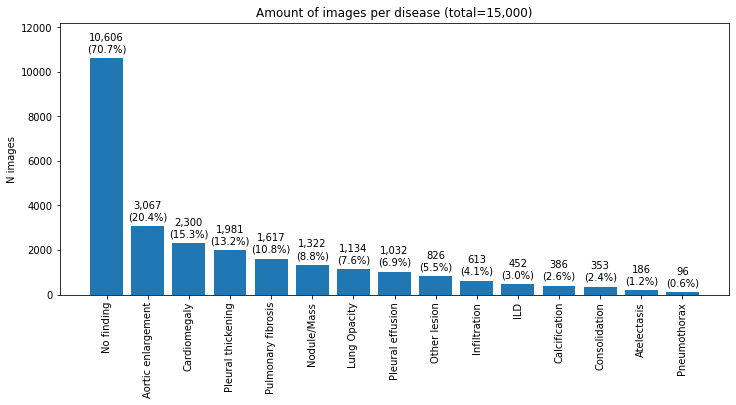

In [203]:
plt.figure(figsize=(12, 5))

plt.bar(diseases, n_images)
plt.xticks(rotation=90)
plt.title(f'Amount of images per disease (total={total_images:,})')
plt.ylabel('N images')

for idx, n_img in enumerate(n_images):
    perc = n_img / total_images * 100
    text = f'{n_img:,}\n({perc:.1f}%)'
    plt.text(idx, n_img + 200, text, va='bottom', ha='center')

plt.ylim(0, int(max(n_images) * 1.15))

## Distribution of diagnoses vs diseases

In [201]:
amounts = Counter(df['class_name']).items()
sorted_amounts = sorted(amounts, key=lambda x: x[1], reverse=True)
diseases, n_diagnoses = zip(*sorted_amounts)
total_diagnoses = sum(n_diagnoses)
total_diagnoses

67914

(0.0, 36590.0)

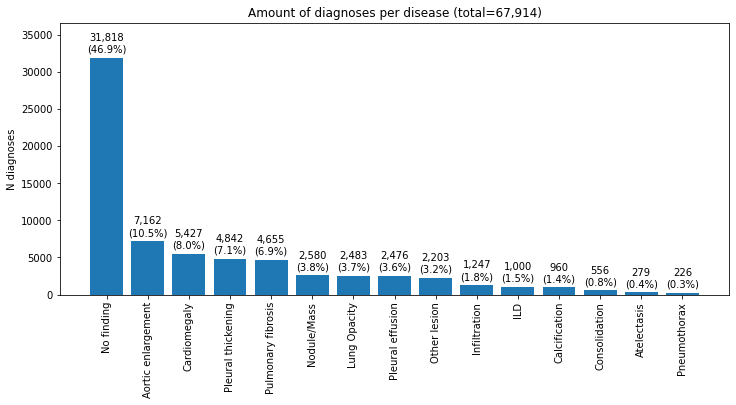

In [204]:
plt.figure(figsize=(12, 5))

plt.bar(diseases, n_diagnoses)
plt.xticks(rotation=90)
plt.title(f'Amount of diagnoses per disease (total={total_diagnoses:,})')
plt.ylabel('N diagnoses')

for idx, n_diag in enumerate(n_diagnoses):
    perc = n_diag / total_diagnoses * 100
    text = f'{n_diag:,}\n({perc:.1f}%)'
    plt.text(idx, n_diag + 500, text, va='bottom', ha='center')

plt.ylim(0, int(max(n_diagnoses) * 1.15))

## Check labels consistency

### Are there multiple radiologists for the same diagnostic?

In [215]:
d = df.loc[df['class_id'] != 14]
d = d.groupby('image_id')[['class_id', 'rad_id']].apply(lambda x: list(x.values))
d

image_id
0005e8e3701dfb1dd93d53e2ff537b6e      [[7, R10], [8, R8], [6, R10], [7, R9], [4, R8]]
0007d316f756b3fa0baea2ff514ce945    [[13, R9], [11, R10], [3, R10], [11, R8], [13,...
000d68e42b71d3eac10ccc077aba07c1    [[9, R8], [9, R10], [9, R9], [9, R9], [11, R9]...
00150343289f317a0ad5629d5b7d9ef9    [[11, R8], [0, R10], [11, R9], [13, R9], [10, ...
001d127bad87592efe45a5c7678f8b8d    [[13, R9], [13, R10], [2, R10], [13, R10], [13...
                                                          ...                        
ff924bcbd38f123aec723aa7040d7e43    [[11, R9], [10, R10], [10, R9], [13, R8], [4, ...
ffb5d0b005261ed350f7a08c06613a34    [[0, R10], [3, R10], [3, R9], [0, R8], [3, R8]...
ffceb71a80efba3b83c88e11f4b9694b    [[13, R14], [3, R13], [3, R14], [3, R11], [13,...
ffe6f9fe648a7ec29a50feb92d6c15a4      [[3, R8], [0, R9], [9, R10], [3, R10], [3, R9]]
ffeffc54594debf3716d6fcd2402a99f                         [[0, R8], [0, R10], [0, R9]]
Length: 4394, dtype: object

In [227]:
repeated_diagnoses = defaultdict(list)

for image_id, diagnoses in d.to_dict().items():
    diagnoses = [tuple(d) for d in diagnoses]
    for diag, amount in Counter(diagnoses).items():
        if amount > 1:
            repeated_diagnoses[image_id].append((diag, amount))
len(repeated_diagnoses)

1892

1,892 images have repeated diagnoses (i.e. same radiologist labeled the same disease more than once)

### Images with multiple diseases

In [228]:
reduced_df = df.groupby('image_id')['class_id'].apply(list)
reduced_df

image_id
000434271f63a053c4128a0ba6352c7f                               [14, 14, 14]
00053190460d56c53cc3e57321387478                               [14, 14, 14]
0005e8e3701dfb1dd93d53e2ff537b6e                            [7, 8, 6, 7, 4]
0006e0a85696f6bb578e84fafa9a5607                               [14, 14, 14]
0007d316f756b3fa0baea2ff514ce945    [13, 11, 3, 11, 13, 0, 5, 5, 0, 11, 13]
                                                     ...                   
ffe6f9fe648a7ec29a50feb92d6c15a4                            [3, 0, 9, 3, 3]
ffea246f04196af602c7dc123e5e48fc                               [14, 14, 14]
ffeffc54594debf3716d6fcd2402a99f                                  [0, 0, 0]
fff0f82159f9083f3dd1f8967fc54f6a                               [14, 14, 14]
fff2025e3c1d6970a8a6ee0404ac6940                               [14, 14, 14]
Name: class_id, Length: 15000, dtype: object

In [229]:
categories = defaultdict(list)

NO_FINDING_IDX = 14

for image_id, diseases in reduced_df.to_dict().items():
    if len(diseases) == 0:
        categories['empty'].append(image_id)
        continue

    unique_diseases = set(diseases)
    if NO_FINDING_IDX in unique_diseases:
        if len(unique_diseases) == 1:
            categories['unique-nofinding'].append(image_id)
        else:
            categories['disease-and-not-disease'].append(image_id)
    else:
        if len(diseases) == len(unique_diseases):
            categories['multilabel'].append(image_id)
        else:
            categories['repeated-bbs'].append(image_id)
    
{(k, len(v)) for k,v in categories.items()}

{('multilabel', 29), ('repeated-bbs', 4365), ('unique-nofinding', 10606)}

In [32]:
10606, 29 + 4365

(10606, 4394)

### Images with multiple BBS

In [2]:
%run ../../utils/shapes.py

In [230]:
def permutations_without_repetition(iterable):
    n = len(iterable)
    for i in range(0, n):
        item1 = iterable[i]
        for j in range(i+1, n):
            item2 = iterable[j]
            yield item1, item2

In [233]:
images_with_multiple_bbs = categories['repeated-bbs']
len(images_with_multiple_bbs)

4365

In [234]:
cols = ['rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
errors = defaultdict(list)

# categories_repeated_bbs = defaultdict(list)
agreement = []

for image_id in tqdm(images_with_multiple_bbs):
    rows = df.loc[df['image_id'] == image_id]
    bbs_by_disease = rows.groupby('class_id')[cols].apply(lambda x: x.values.tolist())
    bbs_by_disease = dict(bbs_by_disease)

    for disease_id, bbs in bbs_by_disease.items():
        if len(bbs) == 0:
            errors['no-bbs'].append((image_id, disease_id))
            continue

        if len(bbs) == 1:
            agreement.append((image_id, disease_id, 1, len(bbs)))
            continue

        average_iou = 0
        permuts = 0
        for bbox1, bbox2 in permutations_without_repetition(bbs):
            iou = calc_iou(bbox1[1:], bbox2[1:])
            average_iou += iou
            permuts += 1

        average_iou /= permuts

        agreement.append((image_id, disease_id, average_iou, len(bbs)))
len(agreement)

  0%|          | 0/4365 [00:00<?, ?it/s]

15255

In [235]:
agreement_df = pd.DataFrame(agreement, columns=['image_id', 'class_id', 'iou', 'n_bbs'])
agreement_df.head()

,image_id,class_id,iou,n_bbs
0,0005e8e3701dfb1dd93d53e2ff537b6e,4,1.000000,1
1,0005e8e3701dfb1dd93d53e2ff537b6e,6,1.000000,1
2,0005e8e3701dfb1dd93d53e2ff537b6e,7,0.958384,2
3,0005e8e3701dfb1dd93d53e2ff537b6e,8,1.000000,1
4,0007d316f756b3fa0baea2ff514ce945,0,0.619907,2


In [236]:
agreement_df.to_csv(os.path.join(DATASET_DIR, 'agreement_df.csv'), index=False)

_Agreement analysis is in a section below_

# Create master files

In [194]:
fpath = os.path.join(DATASET_DIR_OLD, 'train.csv')
df = pd.read_csv(fpath)
df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


## Labels df

In [234]:
import torch
import numpy as np
from ignite.utils import to_onehot

In [208]:
diseases_by_image = df.groupby('image_id')['class_id'].apply(set)
diseases_by_image

image_id
000434271f63a053c4128a0ba6352c7f                 {14}
00053190460d56c53cc3e57321387478                 {14}
0005e8e3701dfb1dd93d53e2ff537b6e         {8, 4, 6, 7}
0006e0a85696f6bb578e84fafa9a5607                 {14}
0007d316f756b3fa0baea2ff514ce945    {0, 3, 5, 11, 13}
                                          ...        
ffe6f9fe648a7ec29a50feb92d6c15a4            {0, 9, 3}
ffea246f04196af602c7dc123e5e48fc                 {14}
ffeffc54594debf3716d6fcd2402a99f                  {0}
fff0f82159f9083f3dd1f8967fc54f6a                 {14}
fff2025e3c1d6970a8a6ee0404ac6940                 {14}
Name: class_id, Length: 15000, dtype: object

In [250]:
diseases_by_image['00053190460d56c53cc3e57321387478']

{14}

In [235]:
images = list(diseases_by_image.index)
labels = torch.stack([
    to_onehot(torch.tensor(list(diseases)), len(VINBIG_DISEASES)).sum(dim=0)
    for diseases in diseases_by_image
], dim=0)
labels = np.array(labels)
len(images), len(diseases_by_image), labels.shape

(15000, 15000, (15000, 15))

In [241]:
labels_df = pd.DataFrame(labels, columns=VINBIG_DISEASES)
labels_df['image_id'] = images
labels_df.head()

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,image_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,000434271f63a053c4128a0ba6352c7f
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,00053190460d56c53cc3e57321387478
2,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0005e8e3701dfb1dd93d53e2ff537b6e
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0006e0a85696f6bb578e84fafa9a5607
4,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0007d316f756b3fa0baea2ff514ce945


In [254]:
# sanity checks
diseases = list(VINBIG_DISEASES)
diseases.remove('No finding')

errors = defaultdict(list)

for index, row in labels_df.iterrows():
    image_id = row['image_id']
    if row['No finding'] == 1:
        if not row[diseases].to_numpy().sum() == 0:
            errors['no-finding-vs-diseases'].append(image_id)
    
    should_have_diseases = diseases_by_image[image_id]
    has_diseases = set([
        index
        for index, value in enumerate(row[VINBIG_DISEASES])
        if value == 1
    ])
    if set(should_have_diseases) != set(has_diseases):
        errors['diseases-wrong'].append(image_id)
        
{(k, len(v)) for k, v in errors.items()}

set()

In [257]:
cols = ['image_id'] + VINBIG_DISEASES[:-1]
labels_df = labels_df[cols]
labels_df.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,000434271f63a053c4128a0ba6352c7f,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00053190460d56c53cc3e57321387478,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0,0,0,0,1,0,1,1,1,0,0,0,0,0
3,0006e0a85696f6bb578e84fafa9a5607,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0007d316f756b3fa0baea2ff514ce945,1,0,0,1,0,1,0,0,0,0,0,1,0,1


In [258]:
fpath = os.path.join(DATASET_DIR, 'labels.csv')
labels_df.to_csv(fpath, index=False)

## BBs dict

In [270]:
import json

In [380]:
%%time

master_dict = defaultdict(list)
keys = ['x_min', 'y_min', 'x_max', 'y_max']

for index, row in df.iterrows():
    image_id = row['image_id']
    class_id = row['class_id']
    
    if class_id == 14:
        continue
    
    x_min, y_min, x_max, y_max = row[keys].to_numpy().astype(int).tolist()
    master_dict[image_id].append((class_id, x_min, y_min, x_max, y_max))

CPU times: user 18.5 s, sys: 37.3 ms, total: 18.5 s
Wall time: 18.6 s


In [381]:
len(master_dict)

4394

In [382]:
fpath = os.path.join(DATASET_DIR, 'bboxes.json')
with open(fpath, 'w') as f:
    json.dump(master_dict, f)

## Add test images to labels.csv

In [21]:
df = pd.read_csv(os.path.join(DATASET_DIR, 'labels.csv'))
len(df)

15000

In [22]:
len(VINBIG_DISEASES)

15

In [50]:
diseases = VINBIG_DISEASES[:-1]
zeros = np.zeros((len(test_images), len(diseases)))
index = [i.replace('.png', '') for i in test_images]
dummy_df = pd.DataFrame(zeros, index=index, columns=diseases)
dummy_df = dummy_df.reset_index().rename(columns={'index': 'image_id'})
print(len(dummy_df))
dummy_df.head()

3000


,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,c5ce86ee4edfdeb82681625ce2c49111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,45a67b52deef6d917675de9efcace27d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,958a4c63f5e4151e78a7a3684eb4616f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8c6c6d7609f644dea5044ac56725cf3a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5d63f31cc8e21664c69bd7613b1b76e4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
full_df = pd.concat([df, dummy_df])
print(len(full_df))
full_df.head()

18000


,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,000434271f63a053c4128a0ba6352c7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00053190460d56c53cc3e57321387478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0005e8e3701dfb1dd93d53e2ff537b6e,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0006e0a85696f6bb578e84fafa9a5607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0007d316f756b3fa0baea2ff514ce945,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [53]:
full_df.to_csv(os.path.join(DATASET_DIR, 'labels.csv'), index=False)

# Calculate mean and std

In [273]:
%run ../../utils/images.py

In [275]:
images_dir = os.path.join(DATASET_DIR, 'images')
images = os.listdir(images_dir)
len(images)

15000

In [276]:
compute_mean_std(ImageFolderIterator(images_dir, images), show=True)

  0%|          | 0/15000 [00:00<?, ?it/s]

(tensor([0.5489, 0.5489, 0.5489]), tensor([0.2498, 0.2498, 0.2498]))

# Split dataset

Only train and validation have real labels

## Make split

In [277]:
import random

In [13]:
SPLITS_DIR = os.path.join(DATASET_DIR, 'splits')

def save_split(items, name):
    filepath = os.path.join(SPLITS_DIR, f'{name}.txt')
    with open(filepath, 'w') as f:
        for item in items:
            f.write(f'{item}\n')

    print(f'List saved to: {filepath}')
    
def load_split(name):
    filepath = os.path.join(SPLITS_DIR, f'{name}.txt')
    with open(filepath, 'r') as f:
        return [l.strip() for l in f.readlines()]

In [279]:
images = os.listdir(os.path.join(DATASET_DIR, 'images'))

In [280]:
VAL_SPLIT = 0.1

In [281]:
val_images = random.sample(images, int(VAL_SPLIT * len(images)))
train_images = list(set(images) - set(val_images))
len(train_images), len(val_images)

(13500, 1500)

## Check split distribution

In [318]:
DISEASES = VINBIG_DISEASES[:-1]

def plot_distribution(images, **kwargs):
    d = labels_df
    
    images = [
        i.replace('.png', '')
        for i in images
    ]
    
    d = d.loc[d['image_id'].isin(set(images))]
    values = d[DISEASES].sum(axis=0)
    
    plt.bar(DISEASES, values, **kwargs)
    plt.xticks(rotation=90)

No handles with labels found to put in legend.


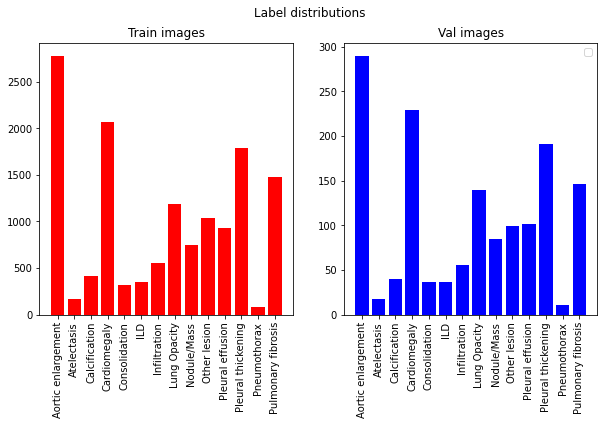

In [319]:
plt.figure(figsize=(10, 5))

plt.suptitle('Label distributions')

plt.subplot(1, 2, 1)
plt.title('Train images')
plot_distribution(train_images, color='red')

plt.subplot(1, 2, 2)
plt.title('Val images')
plot_distribution(val_images, color='blue')

plt.legend()

## Save splits to disk

In [ ]:
save_split(train_images, 'train')
save_split(val_images, 'val')

### Save test split

In [8]:
test_images = [
    image_name.replace('.npy', '.png')
    for image_name in os.listdir(os.path.join(DATASET_DIR_OLD, 'test_np'))
]
len(test_images), test_images[:10]

(3000,
 ['c5ce86ee4edfdeb82681625ce2c49111.png',
  '45a67b52deef6d917675de9efcace27d.png',
  '958a4c63f5e4151e78a7a3684eb4616f.png',
  '8c6c6d7609f644dea5044ac56725cf3a.png',
  '5d63f31cc8e21664c69bd7613b1b76e4.png',
  'df229b77da3656e5264f74025b4990f2.png',
  'e1681b6ced3912b798477d143c7e8f3f.png',
  '2f775125346cd62232d8e835794941c0.png',
  'c7629472a268558926052733d25e66cc.png',
  '97d10edc0bd4a9bdf9265467678944ae.png'])

In [ ]:
save_split(test_images, 'test')

In [15]:
train_images = load_split('train')
val_images = load_split('val')
all_images = train_images + val_images + test_images
len(train_images), len(val_images), len(all_images), len(set(all_images))

(13500, 1500, 18000, 18000)

In [ ]:
save_split(all_images, 'all')

# Plot samples

In [46]:
%run ../vinbig.py
%run ../../utils/__init__.py

In [47]:
dataset = VinBigDataset('train-val', masks=True, bboxes=True)
len(dataset)

15000

In [48]:
item = dataset[4]
item.image.size(), item.labels.shape, len(item.bboxes)

(torch.Size([3, 512, 512]), (14,), 11)

In [49]:
item.masks.size()

torch.Size([14, 512, 512])

## Plot bboxes

In [256]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.font_manager import FontProperties

In [268]:
def plot_sample_with_bboxes(idx, legend_fontsize='medium'):
    item = dataset[idx]
    plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
    plt.title(item.image_fname)
    plt.axis('off')

    if item.bboxes is None or item.bboxes == -1:
        print('Bboxes are not provided by dataset, set bboxes=True')
        return
    
    if len(item.bboxes) == 0:
        print('No bboxes')
        return
    
    ax = plt.gca()
    
    unique_diseases = set(b[0] for b in item.bboxes)
    colors = plt.cm.get_cmap('jet', len(unique_diseases))
    disease_to_color = {d: colors(i) for i, d in enumerate(unique_diseases)}

    handles = []
    labels = []
    
    for i, bbox in enumerate(item.bboxes):
        class_id = bbox[0]
        xmin, ymin, xmax, ymax = bbox[1:]
        width = xmax - xmin
        height = ymax - ymin
        
        color = disease_to_color[class_id]
        rect = Rectangle((xmin, ymin), width, height,
                         edgecolor=color,
                         fill=False, facecolor='none')
        ax.add_patch(rect)
        
        disease_name = VINBIG_DISEASES[class_id]
        if disease_name not in labels:
            handles.append(rect)
            labels.append(disease_name)
    
    fontP = FontProperties()
    fontP.set_size(legend_fontsize)
    plt.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', prop=fontP)

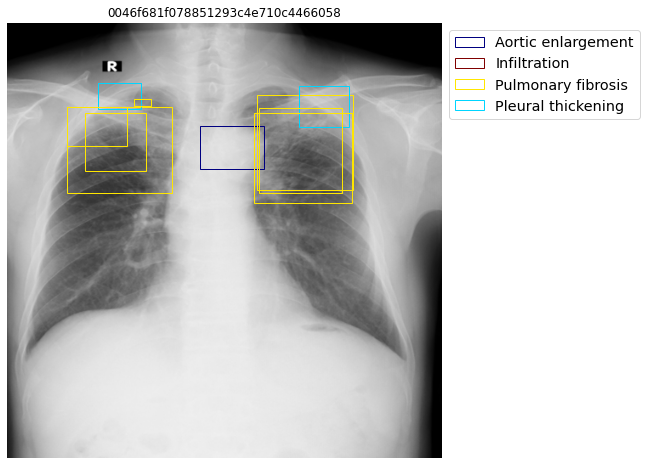

In [270]:
plt.figure(figsize=(10, 8))

fs = 'x-large'
plot_sample_with_bboxes(14, legend_fontsize=fs) # 4, 9, 14

## Plot masks

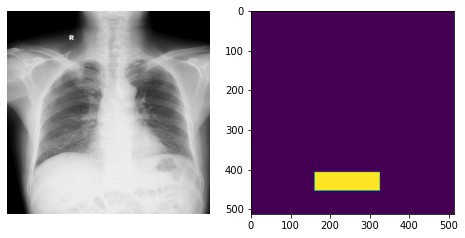

In [16]:
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.imshow(tensor_to_range01(item.image).permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(item.masks[3])

# Disagreement

## Load disagreement dataframe

In [237]:
agreeement_df = pd.read_csv(os.path.join(DATASET_DIR, 'agreement_df.csv'))
agreeement_df.head()

,image_id,class_id,iou,n_bbs
0,0005e8e3701dfb1dd93d53e2ff537b6e,4,1.000000,1
1,0005e8e3701dfb1dd93d53e2ff537b6e,6,1.000000,1
2,0005e8e3701dfb1dd93d53e2ff537b6e,7,0.958384,2
3,0005e8e3701dfb1dd93d53e2ff537b6e,8,1.000000,1
4,0007d316f756b3fa0baea2ff514ce945,0,0.619907,2


In [238]:
agreement_df.sort_values(['iou', 'n_bbs'], ascending=[False, True])

,image_id,class_id,iou,n_bbs
0,0005e8e3701dfb1dd93d53e2ff537b6e,4,1.0,1
1,0005e8e3701dfb1dd93d53e2ff537b6e,6,1.0,1
3,0005e8e3701dfb1dd93d53e2ff537b6e,8,1.0,1
5,0007d316f756b3fa0baea2ff514ce945,3,1.0,1
9,000d68e42b71d3eac10ccc077aba07c1,0,1.0,1
...,...,...,...,...
5967,66332eb5425bcdc6854aae970cc656b9,8,0.0,7
13362,dfd523a5991fc852654bf1235c6282c6,13,0.0,7
14865,f90442f2620175fa21b6afeda865df11,8,0.0,7
2854,3052424d097d8b94d387a20248639d47,8,0.0,8


In [239]:
agreement_df.loc[agreement_df['iou'] <= 0.4]

,image_id,class_id,iou,n_bbs
6,0007d316f756b3fa0baea2ff514ce945,5,0.000000,2
7,0007d316f756b3fa0baea2ff514ce945,11,0.207382,3
8,0007d316f756b3fa0baea2ff514ce945,13,0.056265,3
10,000d68e42b71d3eac10ccc077aba07c1,7,0.000000,2
11,000d68e42b71d3eac10ccc077aba07c1,9,0.035013,10
...,...,...,...,...
15242,ff924bcbd38f123aec723aa7040d7e43,4,0.153144,2
15244,ff924bcbd38f123aec723aa7040d7e43,10,0.201462,6
15245,ff924bcbd38f123aec723aa7040d7e43,11,0.201462,6
15246,ff924bcbd38f123aec723aa7040d7e43,13,0.153201,6


## Plot disagreement

In [274]:
def get_over_disagreement_thresh(df_ious, thresh=0.4):
    over_thresh = df_ious.loc[df_ious['iou'] > thresh]

    # Amounts of diagnoses
    n_dx_over = len(over_thresh)
    n_dx = len(df_ious)
    
    return f'[iou > {thresh:.2f}] {n_dx_over:,} ({n_dx_over / n_dx * 100:.0f}%)'

In [275]:
def plot_disagreement(disease=None, n_bbs=None, bins=20, thresh=0.4):
    df = agreement_df
    
    info = {}
    
    if disease is not None:
        df = df.loc[df['class_id'] == disease]
        info['disease'] = VINBIG_DISEASES[disease]
    
    if n_bbs is not None:
        if isinstance(n_bbs, int):
            n_bbs = (n_bbs,)

        df = df.loc[df['n_bbs'].isin(n_bbs)]
        info['n_bbs'] = n_bbs

    if len(info) == 0:
        title = 'Distribucion IoU en diagnósticos'
    else:
        title = ' '.join(f"{k}={v}" for k, v in info.items())
        
    # print(f'Total diagnoses ({title}): {len(df)}')
    ious = df['iou']
    plt.hist(ious, bins=bins)
    plt.xlabel('IoU promedio entre BBs')
    plt.ylabel(f'N diagnósticos (total={len(df):,})')
    plt.title(title)

    if isinstance(thresh, float):
        text = get_over_disagreement_thresh(df, thresh=thresh)
    elif isinstance(thresh, (tuple, list)):
        text = '\n'.join(
            get_over_disagreement_thresh(df, thresh=t)
            for t in thresh
        )
    
    if text is not None:
        ax = plt.gca()
        plt.text(0.5, 0.9, text,
                 transform=ax.transAxes, ha='center', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                )
    
    return df

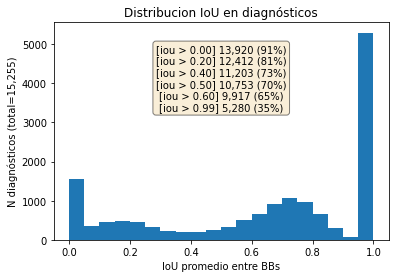

In [276]:
_ = plot_disagreement(thresh=(0, 0.2, 0.4, 0.5, 0.6, 0.99))

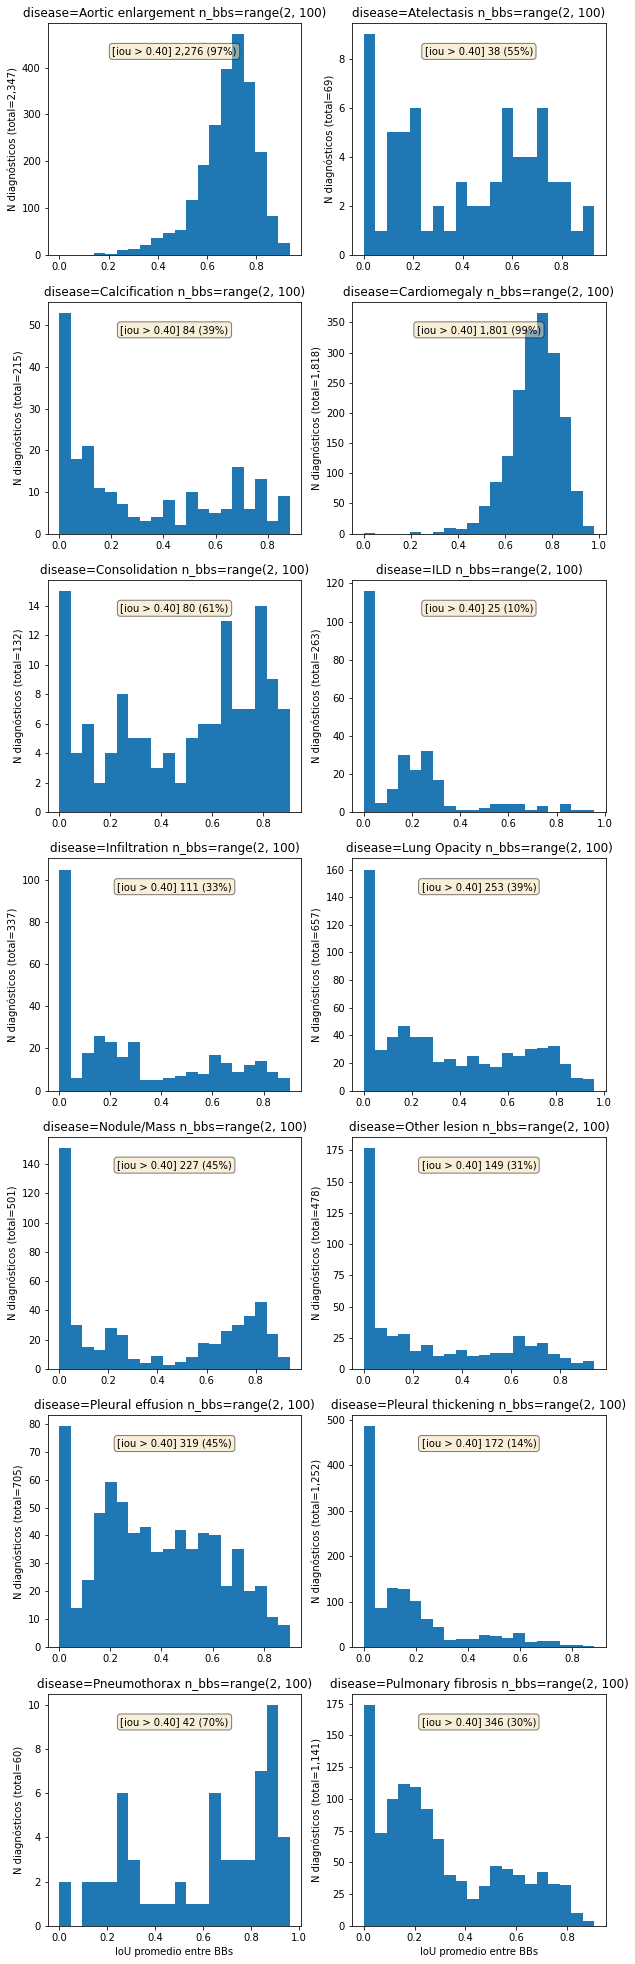

In [277]:
n_rows = 7
n_cols = 2
plt.figure(figsize=(n_cols*5, n_rows*5))

for disease in range(0, 14):
    plt.subplot(n_rows, n_cols, disease+1)
    plot_disagreement(disease=disease, n_bbs=range(2, 100))
    if disease // n_cols + 1 != n_rows:
        plt.xlabel('')

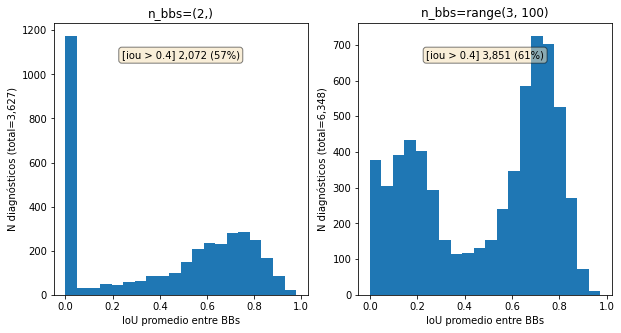

In [189]:
n_rows = 1
n_cols = 2
plt.figure(figsize=(n_cols*5, n_rows*5))

plt.subplot(n_rows, n_cols, 1)
plot_disagreement(n_bbs=2)

plt.subplot(n_rows, n_cols, 2)
_ = plot_disagreement(n_bbs=range(3, 100))